# Hello, FABRIC: Create your first FABRIC slice


## Configure the Environment

### Create the FABRIC Proxies

The FABRIC API is used via proxy objects that manage connections to the control framework. 


In [9]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [2]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [3]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host ,project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [4]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: UKY
	Components:
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
	Site Interfaces:
		UKY_LBNL: TrunkPort { bw: 100/100 Gbps}
RENC
	Components:
	Site Interfaces:
STAR
	Components:
	Site Interfaces:
LBNL
	Components:
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
	Site Interfaces:
		LBNL_UKY: TrunkPort { bw: 10/10 Gbps}
Links:
	port+lbnl-data-sw:TenGigE0/0/0/6/0.2400-link[L2Path]: ['UKY_LBNL', 'LBNL_UKY']

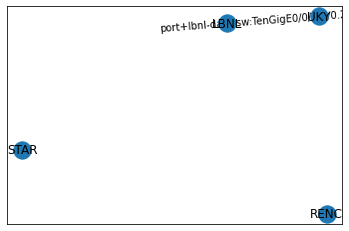

In [5]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

Creates a single node with basic compute capabilities.

<img src="./figs/SingleNode.png" width="40%"><br>


In [6]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
myExperiment = ExperimentTopology()

# Add node
myNode = myExperiment.add_node(name='myNode1', site='LBNL')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=16, disk=100)

# Set Properties
myNode.set_properties(capacities=cap, image_type='qcow2', image_ref='default_centos_8')

# Generate Slice Graph
slice_graph = myExperiment.serialize()

ssh_key = None
with open ("/Users/pruth/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='hello-fabric', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "cb3e392b-dd69-442d-aa4f-fa7a41211656",
    "lease_end": "2021-08-17 15:36:18",
    "pending_state": "None_",
    "reservation_id": "d4ffe8d1-b1a0-4b22-8231-703f0aec5f0b",
    "reservation_state": "Unknown",
    "slice_id": "d2e71aa8-1957-462d-9597-4ed15322bdf7"
}]


In [7]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [ ]:
status, slices = slice_manager.slices(state="All")

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

## Query Slivers

In [ ]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

## Sliver Status

In [ ]:
for s in slivers:
    status, sliver_status = slice_manager.sliver_status(slice_id=slice_id, sliver_id=s.reservation_id)

    print("Response Status {}".format(status))
    if status == Status.OK:
        print()
        print("Sliver Status {}".format(sliver_status))
        print()

## Log into the nodes

In [ ]:
script= '#!/bin/bash  \n' \
        'echo Hello, FABRIC from node `hostname -s`   \n'

In [ ]:
import paramiko 
#from scp import SCPClient, SCPException

key = paramiko.RSAKey.from_private_key_file("/Users/pruth/.ssh/id_rsa")
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

for sliver in slivers:
    node_name = sliver.name
    management_ip = sliver.management_ip
    
    print("Node {0} IP {1}".format(node_name, management_ip))
    
    client.connect(management_ip,username='centos',pkey = key)

    stdin, stdout, stderr = client.exec_command('echo \"' + script + '\" > script.sh; chmod +x script.sh; sudo ./script.sh')
    print ('')
    print (str(stdout.read(),'utf-8').replace('\\n','\n'))

    client.close()

## Delete Slice

In [8]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
